# Fitting Playground 
Place to try things out.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import vegas 

%matplotlib inline

In [2]:
plt.rc('font', family='serif')
plt.rc('font', size=16)

Define some constants.

In [3]:
TO_RADIANS = np.pi/180.0
TO_DEGREES = 1/TO_RADIANS

In [4]:
dataset = pd.read_csv('https://userweb.jlab.org/~dmriser/lfs/phi-dist.csv')

In [5]:
AXIS     = 'z'
AXIS_BIN = 5

In [6]:
data = dataset.query('axis == "%s" and axis_bin == %d' % (AXIS, AXIS_BIN))

Look at the distribution that we are trying to fit.

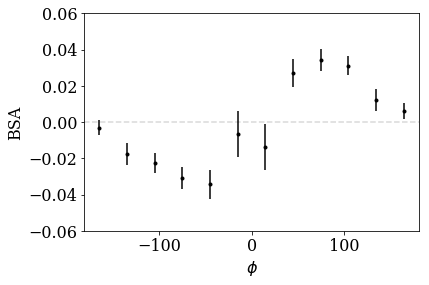

In [7]:
plt.errorbar(x=data.phi, y=data.value, yerr=data.stat,
            linestyle='', marker='.', color='black')
plt.ylim([-0.06, 0.06])
plt.xlabel('$\phi$')
plt.ylabel('BSA')
plt.axhline(0.0, linestyle='--', color='black', alpha=0.15)

In [8]:
def physics_model(phi, a):
    return a[0]*np.sin(phi*TO_RADIANS)/(1+a[1]*np.cos(phi*TO_RADIANS)+a[2]*np.cos(2*phi*TO_RADIANS))

In [9]:
def likelihood(data, theory, error):
    return np.exp(-0.5*np.sum(((data-theory)/error)**2))

In [10]:
def integrand(phi, data, error, model, a):
    theory = model(phi, a)
    f = likelihood(data, theory, error)
    return [f, f*a[0], f*a[1], f*a[2], 
            f*a[0]**2, f*a[1]**2, f*a[2]**2] 

In [ ]:
def perform_vegas(integrand, bounds, phi, data, error, model, n_iter, n_eval):
    vegas_integrator = vegas.Integrator(bounds)
    
    # burning some 
    vegas_integrator(lambda p: integrand(phi, data, error, model, p), 
                    nitn=4, 
                    neval=1000)
    
    result = vegas_integrator(lambda p: integrand(phi, data, error, model, p), 
                    nitn=n_iter, 
                    neval=n_eval)
    
    print(result.summary())
    
    results = {}
    results['z'] = result[0].mean
    results['Q'] = result.Q
    results['exp_par1'] = result[1].mean/results['z']
    results['exp_par2'] = result[2].mean/results['z']
    results['exp_par3'] = result[3].mean/results['z']
    results['var_par1'] = result[4].mean/results['z']-results['exp_par1']**2
    results['var_par2'] = result[5].mean/results['z']-results['exp_par2']**2
    results['var_par3'] = result[6].mean/results['z']-results['exp_par3']**2
    return results

In [ ]:
bounds = [[-1,1],[-1,1],[-1,1]]
result = perform_vegas(integrand, bounds, data.phi, data.value, data.stat, physics_model, 12, 4000)

In [ ]:
result

In [ ]:
print('%.3f +/- %.3f' % (result['exp_par1'], np.sqrt(result['var_par1'])))

In [ ]:
print('%.3f +/- %.3f' % (result['exp_par2'], np.sqrt(result['var_par2'])))

In [ ]:
print('%.3f +/- %.3f' % (result['exp_par3'], np.sqrt(result['var_par3'])))